Stworzenie transform

In [1]:
from torchvision import transforms

mytransform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)
])

train_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.3),
    transforms.RandomVerticalFlip(p=0.3),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.15, contrast=0.15),
    transforms.Resize((128,128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)
])

Zrobienie image folderów, sprawdzenie klas i wielkości pobranych zbiorów

In [2]:
from torchvision.datasets import ImageFolder

train_dataset = ImageFolder("dataset/train", transform=train_transforms)
test_dataset = ImageFolder("dataset/test", transform=mytransform)
valid_dataset = ImageFolder("dataset/valid", transform=mytransform)

print("Klasy:", train_dataset.classes)
print("Wielkość train:", len(train_dataset))
print("Wielkość test:", len(test_dataset))
print("Wielkość valid:", len(valid_dataset))

Klasy: ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']
Wielkość train: 1767
Wielkość test: 253
Wielkość valid: 504


Wczytanie folderów z obrazkami

In [ ]:
from torch.utils.data import DataLoader

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4, pin_memory=True)
valid_loader = DataLoader(valid_dataset, batch_size=64, shuffle=False)
test_loader  = DataLoader(test_dataset,  batch_size=64, shuffle=False)

Sprawdzenie czy dobrze wczytuje się batch

In [11]:
images, labels = next(iter(train_loader))
print("Batch images shape:", images.shape)
print("Etykiety batcha:", labels)

Batch images shape: torch.Size([64, 3, 128, 128])
Etykiety batcha: tensor([0, 3, 4, 3, 4, 1, 1, 4, 4, 3, 1, 1, 4, 0, 0, 4, 3, 1, 1, 1, 0, 4, 3, 1,
        1, 0, 4, 2, 4, 3, 2, 2, 0, 0, 0, 4, 2, 1, 3, 5, 3, 3, 0, 1, 1, 1, 2, 3,
        2, 3, 2, 4, 3, 2, 0, 4, 0, 2, 3, 1, 1, 4, 5, 2])


Zliczanie etykiet w zbiorze treningowym i sprawdzenie jak liczne są poszczególne rodzaje przedmiotów na zdjęciach, żeby dowiedzieć się czy są zrównoważone

In [12]:
from collections import Counter

train_labels = [label for _, label in train_dataset]
train_counts = Counter(train_labels)
class_names = train_dataset.classes
class_counts_named = {class_names[i]: train_counts[i] for i in train_counts}

print("Liczba obrazów w każdej klasie (train):")
for cls, count in class_counts_named.items():
    print(f"{cls}: {count}")


Liczba obrazów w każdej klasie (train):
cardboard: 275
glass: 352
metal: 284
paper: 423
plastic: 340
trash: 93


Graficzne przedstawienie danych (nie są zrównoważone, bo śmieci jest za mało)

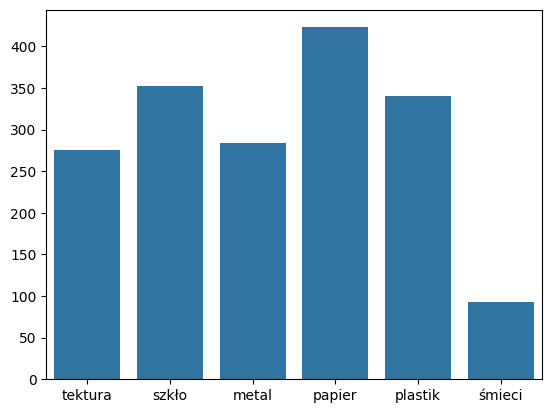

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

labels = ["tektura", "szkło", "metal", "papier", "plastik", "śmieci"]
values = [275, 352, 284, 423, 340, 93]

sns.barplot(x=labels, y=values)
plt.show()


Załadowanie potrzebnych bibliotek

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F


Stworzenie modelu sieci neuronowej

In [5]:
class MyCNN(nn.Module):
    def __init__(self, num_classes=6):
        super().__init__()

        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(16)
        )

        self.conv2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(2)
        )

        self.conv3 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64)
        )

        self.conv4 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(2)
        )

        self.conv5 = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(2)
        )

        self.flatten_size = 128 * 16 * 16

        self.fc1 = nn.Linear(self.flatten_size, 512)
        self.dropout1 = nn.Dropout(0.3)
        self.fc2 = nn.Linear(512, 256)
        self.dropout2 = nn.Dropout(0.3)
        self.fc_out = nn.Linear(256, num_classes)

        self._initialize_weights()

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)

        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)
        x = F.relu(self.fc2(x))
        x = self.dropout2(x)
        x = self.fc_out(x)
        return x

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0.0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1.0)
                nn.init.constant_(m.bias, 0.0)


Sprawdzenie czy na pewno jest używany cuda i wczytanie modelu

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model = MyCNN(num_classes=6).to(device)

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print("Device:", device)
print("Parameters modelu:", count_parameters(model))


Device: cuda
Model parameters: 17156358


Sprawdzenie czy dobrze pobiera się batch z train_loadera

In [14]:

images, labels = next(iter(train_loader))
images = images.to(device)
out = model(images)
print(out.shape)


torch.Size([64, 6])


Obliczenie wag dla poszczególnych klas

In [7]:
from collections import Counter
import torch
import math

train_labels = [label for _, label in train_dataset]
counts = Counter(train_labels)
num_classes = len(train_dataset.classes)
class_counts = [counts[i] for i in range(num_classes)]
total = sum(class_counts)
class_weights = [math.sqrt(total / c) for c in class_counts]
weight_sum = sum(class_weights)
class_weights_normalized = [w / weight_sum for w in class_weights]
device = "cuda" if torch.cuda.is_available() else "cpu"
class_weights_tensor = torch.tensor(class_weights_normalized, dtype=torch.float).to(device)
for i, cls_name in enumerate(train_dataset.classes):
    print(f"Klasa {cls_name}: {class_counts[i]} przykładów, waga {class_weights_tensor[i]:.2f}")

Klasa cardboard: 275 przykładów, waga 0.16
Klasa glass: 352 przykładów, waga 0.14
Klasa metal: 284 przykładów, waga 0.16
Klasa paper: 423 przykładów, waga 0.13
Klasa plastic: 340 przykładów, waga 0.14
Klasa trash: 93 przykładów, waga 0.27


Załadowanie criteriona (CrossEntropyLoss) i optimizera (Adam)

In [8]:
import torch.nn as nn
import torch.optim as optim

criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)
optimizer = optim.Adam(model.parameters(), lr=0.0004, weight_decay=1e-4)

Pętla trenująca i stworzenie wykresów na bazie danych z epok

Epoch 1/45 - Train Loss: 3.5674 - Valid Loss: 2.0495 - Acc: 0.3492 - Prec: 0.3995 - Rec: 0.3174 - F1: 0.2588
Epoch 2/45 - Train Loss: 1.8913 - Valid Loss: 1.2788 - Acc: 0.5417 - Prec: 0.5339 - Rec: 0.5010 - F1: 0.5010
Epoch 3/45 - Train Loss: 1.6800 - Valid Loss: 1.0117 - Acc: 0.6409 - Prec: 0.6243 - Rec: 0.6487 - F1: 0.6291
Epoch 4/45 - Train Loss: 1.4366 - Valid Loss: 1.0471 - Acc: 0.6429 - Prec: 0.6309 - Rec: 0.6301 - F1: 0.6194
Epoch 5/45 - Train Loss: 1.3857 - Valid Loss: 0.9425 - Acc: 0.6607 - Prec: 0.6626 - Rec: 0.6684 - F1: 0.6444
Epoch 6/45 - Train Loss: 1.2691 - Valid Loss: 0.9332 - Acc: 0.6627 - Prec: 0.6469 - Rec: 0.6546 - F1: 0.6377
Epoch 7/45 - Train Loss: 1.2413 - Valid Loss: 0.8367 - Acc: 0.7103 - Prec: 0.7208 - Rec: 0.6926 - F1: 0.7007
Epoch 8/45 - Train Loss: 1.2192 - Valid Loss: 0.9130 - Acc: 0.6885 - Prec: 0.6871 - Rec: 0.6857 - F1: 0.6744
Epoch 9/45 - Train Loss: 1.1302 - Valid Loss: 0.8861 - Acc: 0.6984 - Prec: 0.6880 - Rec: 0.7034 - F1: 0.6917
Epoch 10/45 - Train

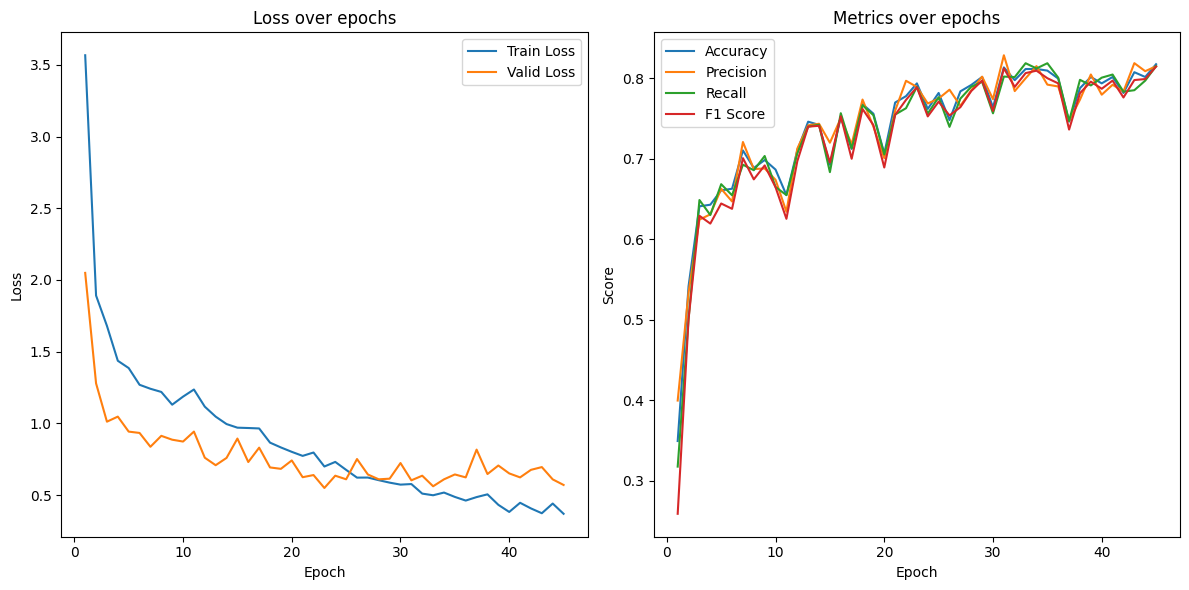

In [9]:
import torch
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import matplotlib.pyplot as plt

train_losses = []
valid_losses = []
accuracies = []
precisions = []
recalls = []
f1_scores = []

def evaluate_model(model, dataloader, device):
    model.eval()
    all_preds = []
    all_labels = []
    total_loss = 0.0
    criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)
    
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            total_loss += loss.item() * inputs.size(0)
            
            preds = torch.argmax(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    avg_loss = total_loss / len(dataloader.dataset)
    acc = accuracy_score(all_labels, all_preds)
    prec = precision_score(all_labels, all_preds, average='macro', zero_division=0)
    rec = recall_score(all_labels, all_preds, average='macro', zero_division=0)
    f1 = f1_score(all_labels, all_preds, average='macro', zero_division=0)
    
    return avg_loss, acc, prec, rec, f1

num_epochs = 45

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
    
    train_loss = running_loss / len(train_loader.dataset)
    valid_loss, acc, prec, rec, f1 = evaluate_model(model, valid_loader, device)
    
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    accuracies.append(acc)
    precisions.append(prec)
    recalls.append(rec)
    f1_scores.append(f1)
    
    print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f} "
          f"- Valid Loss: {valid_loss:.4f} - Acc: {acc:.4f} "
          f"- Prec: {prec:.4f} - Rec: {rec:.4f} - F1: {f1:.4f}")

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs+1), valid_losses, label='Valid Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs+1), accuracies, label='Accuracy')
plt.plot(range(1, num_epochs+1), precisions, label='Precision')
plt.plot(range(1, num_epochs+1), recalls, label='Recall')
plt.plot(range(1, num_epochs+1), f1_scores, label='F1 Score')
plt.xlabel('Epoch')
plt.ylabel('Score')
plt.title('Metrics over epochs')
plt.legend()

plt.tight_layout()
plt.show()


Wyświetlenie Confusion matrix i sprawdzenie statystyk na bazie danych z testu

In [10]:
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for imgs, labels in test_loader:
        imgs = imgs.to(device)
        labels = labels.to(device)

        out = model(imgs)
        preds = out.argmax(dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

from sklearn.metrics import confusion_matrix, classification_report

cm = confusion_matrix(all_labels, all_preds)
print("\nConfusion matrix:\n", cm)

print("\nClassification report:\n")
print(
    classification_report(
        all_labels,
        all_preds,
        target_names=test_dataset.classes,
        digits=4
    )
)



Confusion matrix:
 [[38  1  0  4  1  0]
 [ 0 37  2  3  4  1]
 [ 1  5 30  0  1  3]
 [ 2  0  3 57  1  1]
 [ 1  8  1  5 28  1]
 [ 3  0  0  0  2  9]]

Classification report:

              precision    recall  f1-score   support

   cardboard     0.8444    0.8636    0.8539        44
       glass     0.7255    0.7872    0.7551        47
       metal     0.8333    0.7500    0.7895        40
       paper     0.8261    0.8906    0.8571        64
     plastic     0.7568    0.6364    0.6914        44
       trash     0.6000    0.6429    0.6207        14

    accuracy                         0.7866       253
   macro avg     0.7644    0.7618    0.7613       253
weighted avg     0.7872    0.7866    0.7850       253



Wnioski do zadania:
Model osiągnął stabilną i stosunkowo wysoką skuteczność, stopniowo poprawiając wyniki w trakcie 45 epok treningu. Początkowa dokładność na poziomie ~35% w pierwszej epoce rosła w sposób konsekwentny aż do wartości ~82% accuracy na zbiorze walidacyjnym w ostatniej epoce. Świadczy to o skutecznym procesie uczenia oraz prawidłowym doborze hiperparametrów. Na zbiorze testowym model uzyskał bardzo bliskie wyniki (~78% accuracy) do tych z treningowych, co oznacza, że nie wystąpił tutaj overfitting i poprawnie został wytrenowany. Można jednak zauważyć, że ze wszystkich klas model najgorzej radził sobie z klasą śmieci, co jest głównie spowodowane niezrównoważeniem datasetu. Można więc podsumować, że model nie jest idealny, lecz całkiem dobrze rozpoznaje podane 6 klas.